In [1]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from scipy.special import sinc
# import matplotlib_settting
from nozzle import Spectral, Params, Nozzle

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s

# sine DVR
Let $\psi_n(z) = \sqrt{\frac{2}{L}}\sin(\frac{n\pi}{L}(z-x_0)), n=1,\cdots,N$ be the orthorgonal functions on $[x_0,L]$. Then the "coordinate basis" functions is given by

$$ u_j(z) = w_j\sum_{n=1}^N \psi_n(z)\psi_n^*(z_j) $$

where $w_j$ is the j-th weight for the selected quadrature rule and $u_j$ satisfy the Kronecker delta property
$$ u_j(x_k) = \delta_{jk} $$

Now the solution becomes
$$ \xi(z) = \sum_{n=1}^{N} a_n u_n(z) $$

Text(0.5, 1.0, '$ \\int_0^\\pi u_i(x)u_j(x) $')

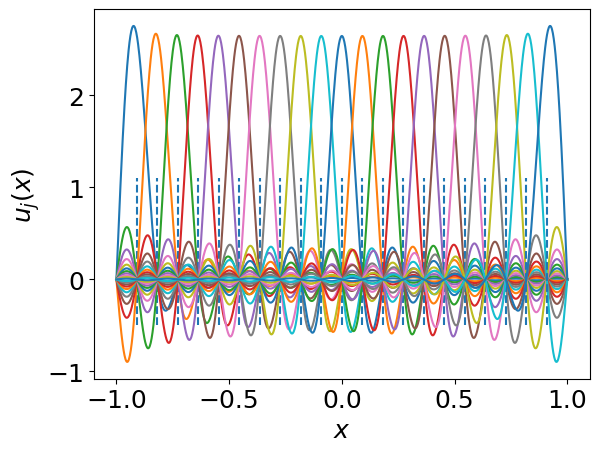

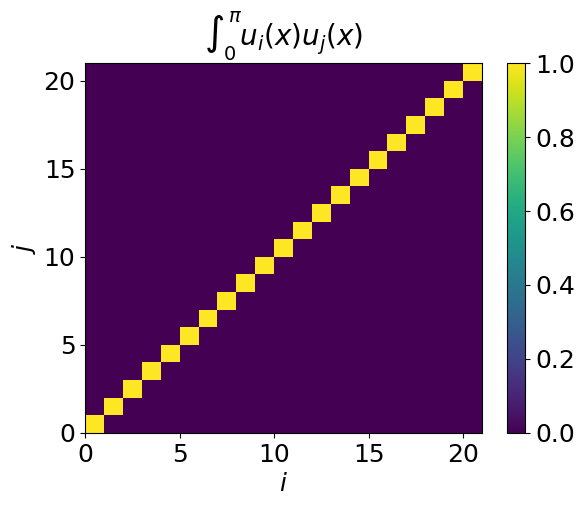

In [8]:
N = 21
L = 2
x0 = -1

xq = np.arange(1,N+1)*L/(N+1) + x0  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
psi = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))
psi_p = lambda x,n: np.sqrt(2/L)*n*np.pi/L*np.cos(n*np.pi/L*(x-x0)) 

def unnomalized_u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

c = quad(lambda x: unnomalized_u(x,0)*unnomalized_u(x,0), xq,wq)
def u(x,j):
    return unnomalized_u(x,j)/np.sqrt(c)

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)/np.sqrt(c)
    return wq[j]*s

x = np.linspace(x0,x0+L,1000)
plt.figure()
for j in range(N):
    plt.plot(x, u(x,j))
    plt.vlines(xq[j], -0.5,1.1,linestyles='--')
plt.ylabel("$u_j(x)$")
plt.xlabel("$x$")

plt.figure()
integrals = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
plt.pcolormesh(integrals)
plt.colorbar()
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.title("$ \int_0^\pi u_i(x)u_j(x) $")

In [4]:
v0 = 0.5
O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A21[i,j] = (1-v0**2)*quad(lambda x: u_p(x,i)*u_p(x,j),xq,wq)
        A22[i,j] = -2j*v0*quad(lambda x: u(x,i)*u_p(x,j),xq,wq)
A = np.block([[O,I],[A21,A22]])

<AxesSubplot:xlabel='x', ylabel='v'>

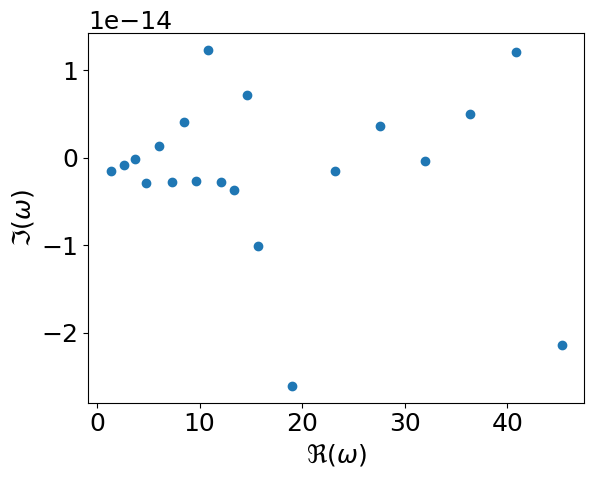

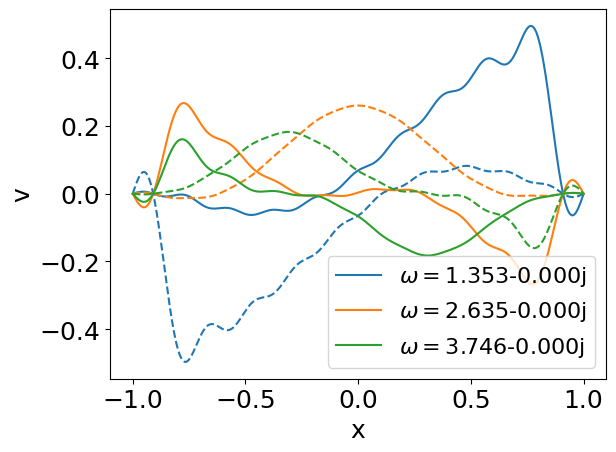

In [6]:
params = Params(Mm=v0, constant_v=True)
nozzle = Nozzle(params, x, u)
nozzle.solve(A)
nozzle.sort_solutions(real_range=[0.1,50])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions()

# sinc DVR
Using the normalized $sinc$ function from scipy. 
$$sinc = \frac{\sin(\pi x)}{\pi x}$$

Text(0.5, 1.0, '$ \\int_{-1}^{1} u_i(x)u_j(x) $')

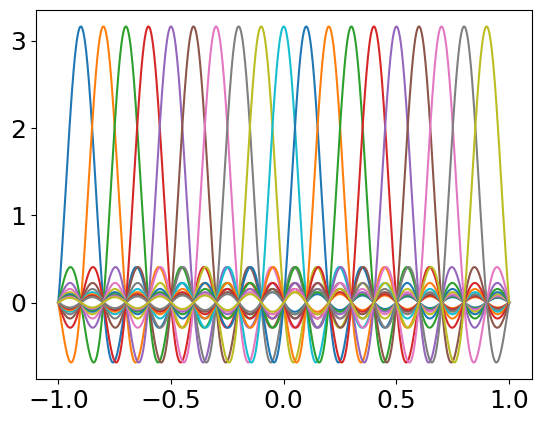

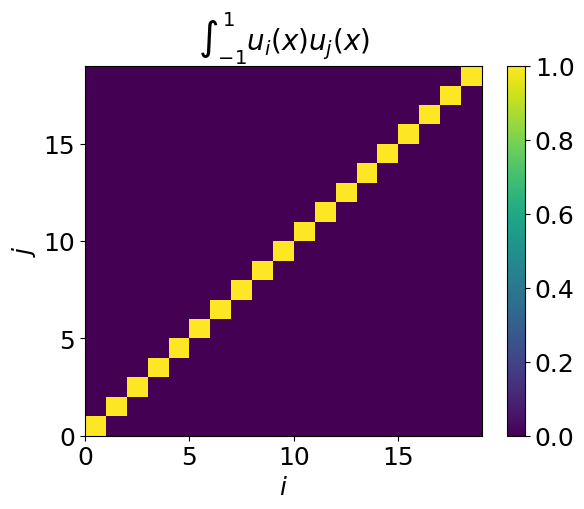

In [9]:
dx = 0.1
x_range = [-1,1]
xq = np.arange(x_range[0],x_range[1]+dx,dx)  # quadrature points
wq = dx*np.ones_like(xq) # quadrature weights

N = xq.size-2
u = lambda x,n: sinc((x-xq[n+1])/dx)/np.sqrt(dx)
u_p = lambda x,n: np.piecewise(
    x, 
    [~np.isclose((x-xq[n+1])/dx, 0)], 
    [lambda x: (np.pi*(x-xq[n+1])/dx*np.cos(np.pi*(x-xq[n+1])/dx)-np.sin(np.pi*(x-xq[n+1])/dx))/(np.pi*(x-xq[n+1])**2/dx)/np.sqrt(dx), 0]
)


x = np.linspace(*x_range,1000)

plt.figure()
for n in range(N):
    plt.plot(x,u(x,n),label=f"$u_{n}$")
#plt.legend()

plt.figure()
integrals = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
plt.pcolormesh(integrals)
plt.colorbar()
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.title("$ \int_{%d}^{%d} u_i(x)u_j(x) $"%tuple(x_range))

In [10]:
v0 = 0.5
O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A21[i,j] = (1-v0**2)*quad(lambda x: u_p(x,i)*u_p(x,j),xq,wq)
        A22[i,j] = -2j*v0*quad(lambda x: u(x,i)*u_p(x,j),xq,wq)
A = np.block([[O,I],[A21,A22]])

<AxesSubplot:xlabel='x', ylabel='v'>

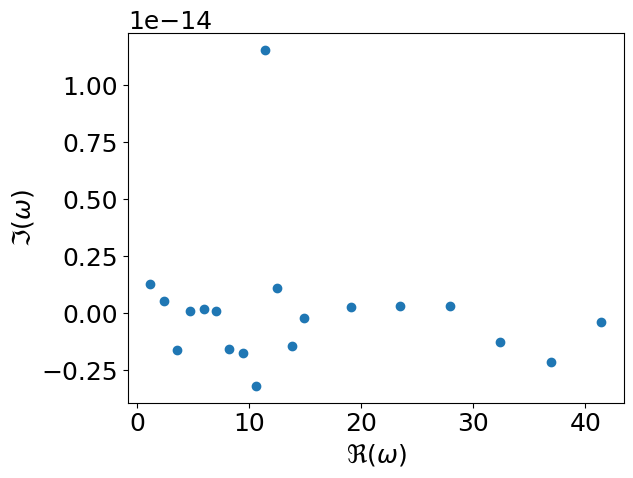

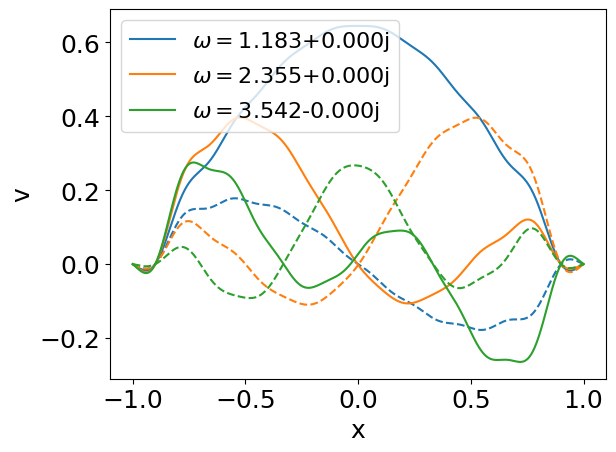

In [11]:
params = Params(Mm=v0, constant_v=True)
nozzle = Nozzle(params, x, u)
nozzle.solve(A)
nozzle.sort_solutions(real_range=[0.1,50])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions()